## Install PIL

Python imaging library is not available by default on Cloud Datalab, fix this.

In [ ]:
%bash
apt-get install -y libjpeg-dev
pip install pillow

## Params

In [ ]:
NUM_POINTS = 200

In [285]:
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance, ImageOps
from IPython import display
import math
import operator
import numpy

In [ ]:
%%storage read --object gs://element-ai-research/greek-statue.jpg -v image_raw

In [39]:
def sub(x,y):
  return tuple(map(operator.sub, x, y))

def add(x,y):
  return tuple(map(operator.add, x, y))

def mul(x,y):
  return tuple(map(operator.mul, x, y))

def div(x,y):
  return tuple(map(operator.div, x, y))

def length(x):
  return math.sqrt(sum(map(lambda x: x*x, x)))

def divk(x, y):
  return tuple(map(operator.div, x, [y for i in range(len(x))]))

def mulk(x, y):
  return tuple(map(operator.mul, x, [y for i in range(len(x))]))

def to_int(x):
  return tuple(map(int, x))

In [343]:
from StringIO import StringIO
image = Image.open(StringIO(image_raw))
image = image.filter(ImageFilter.FIND_EDGES)
image = ImageOps.invert(image)
result = Image.new('RGBA', mulk(image.size, 2), (200,200,200,255))
center = sub(divk(image.size, 2.0), (1,1))
radius = min(center)
image = ImageEnhance.Color(image).enhance(0)
drw = ImageDraw.Draw(image)
drw_res = ImageDraw.Draw(result)

pts = []
for i in range(NUM_POINTS):
  theta = 2 * math.pi * i / NUM_POINTS
  pts.append(add(center, mulk((math.cos(theta), math.sin(theta)), radius)))

In [159]:
def for_all_pixels_in_line(i, j, func):
  d = sub(pts[j], pts[i])
  l = length(d)
  d = divk(d, l)
  p = pts[i]
  for step in range(int(math.ceil(l))):
    func(i, j, to_int(p))
    p = add(p, d)

def for_all_pixels_in_lines(func):
  for i in range(NUM_POINTS - 1):
    for j in range(i + 1, NUM_POINTS):
      for_all_pixels_in_line(i, j, func)

In [160]:
pix_to_lines = {(x,y): [] for x in range(int(center[0] - radius - 1), int(center[0] + radius + 1))
                         for y in range(int(center[1] - radius - 1), int(center[1] + radius + 1))}

def add_line_to_pixel(i, j, p):
  pix_to_lines[p].append((i,j))

for_all_pixels_in_lines(add_line_to_pixel)

In [344]:
line_to_intensity = numpy.zeros((NUM_POINTS, NUM_POINTS))

def black_intensity_at(p):
  return 255 - image.getpixel(p)[0]

for pix, lines in pix_to_lines.items():
  if len(lines) > 0:
    intensity = black_intensity_at(pix)
    for line in lines:
      line_to_intensity[line[0]][line[1]] += intensity

In [319]:
cached_line_intensity = line_to_intensity.copy()

In [244]:
line_to_intensity = cached_line_intensity.copy()

In [222]:
def erase_pixel(i, j, p):
  intensity = black_intensity_at(p)
  for line in pix_to_lines[p]:
    line_to_intensity[line] -= intensity
  drw.point(p, (255,255,255,255))

def draw_next_line():
  max = (0, 0, 0)
  for i in range(NUM_POINTS - 1):
    for j in range(i + 1, NUM_POINTS):
      d = sub(pts[j], pts[i])
      intensity = line_to_intensity[i][j] / length(d)
      if intensity > max[2]:
        max = (i, j, intensity)
  for_all_pixels_in_line(max[0], max[1], erase_pixel)
  drw_res.line(mulk(pts[max[0]] + pts[max[1]], 2.0), (0,0,0,255))

In [351]:
for i in range(600):
  draw_next_line()

In [337]:
draw_next_line()

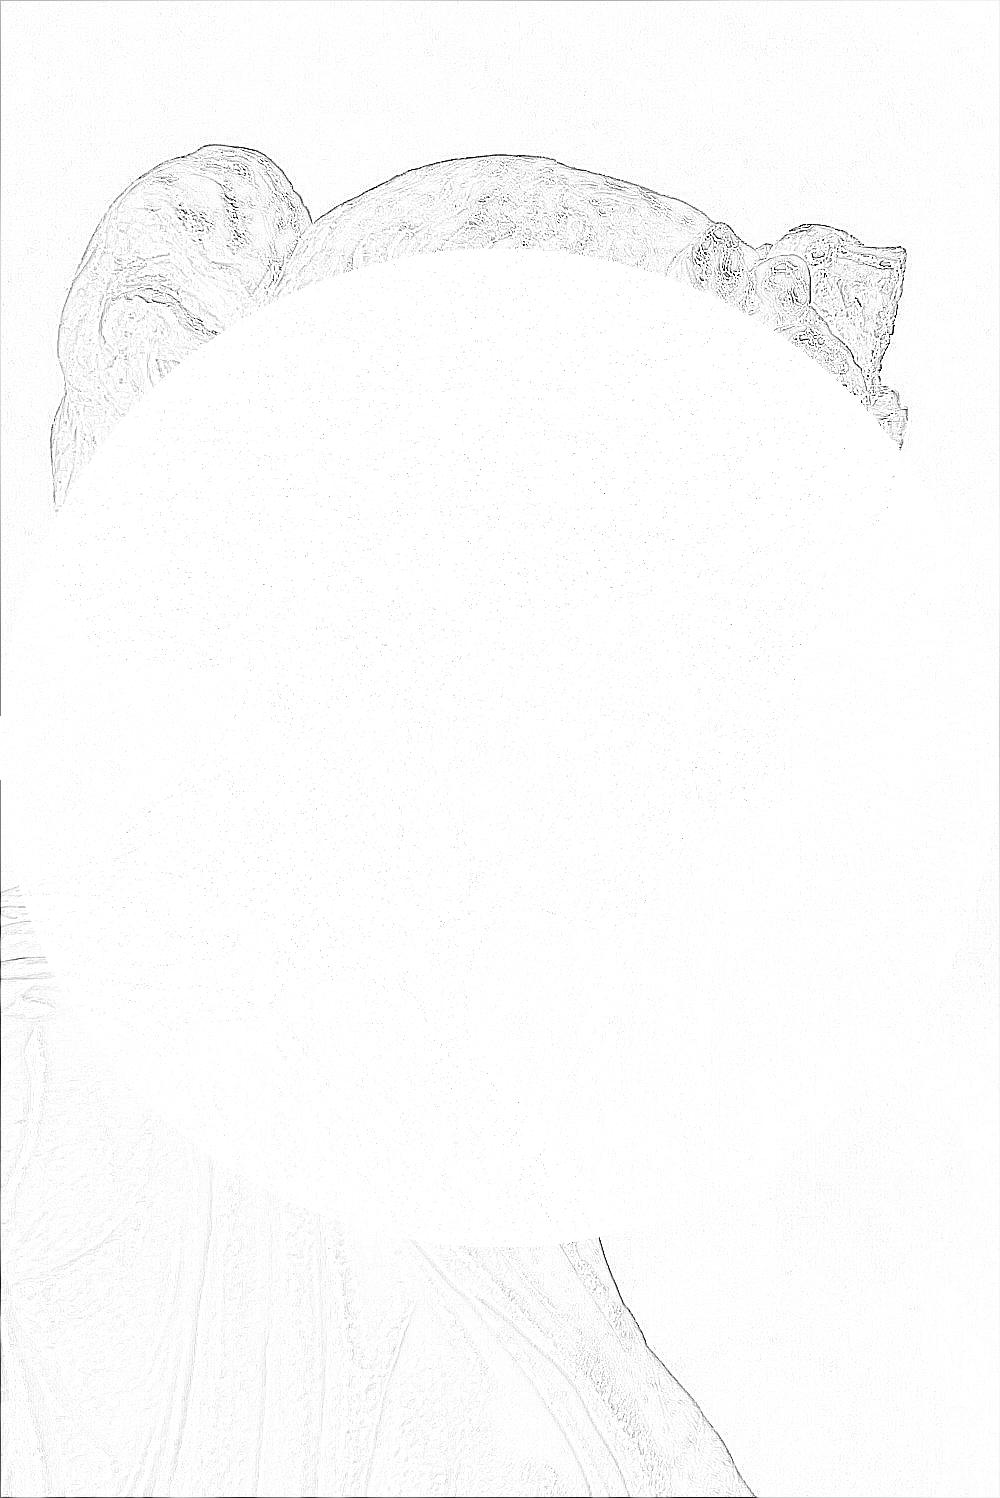

In [352]:
myio = StringIO()
image.save(myio, format='jpeg')
display.Image(data=myio.getvalue(), format='jpg')

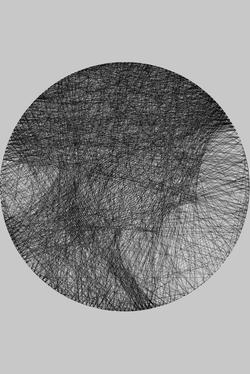

In [353]:
myio = StringIO()
result.resize(to_int(mulk(image.size, 0.25)), Image.LANCZOS).save(myio, format='jpeg')
#result.save(myio, format='jpeg')
display.Image(data=myio.getvalue(), format='jpg')